#### First, let's import popular Python packages and other libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_full = pd.read_csv('final.csv')

In [3]:
df_full = df_full.drop(['Unnamed: 0'], axis=1) #dropping useless column Unnamed: 0

In [4]:
df_full.head()

,Passwords,length,Has_Upper,Has_Numeric,Has_SpecialChar,UpperCase_Count,LowerCase_Count,Numeric_Count,SpecialChar_Count,Alphabet_Count,Password_Source,Has_Word,Has_Name,Has_Place,Score,Password_Strength
0,@fl!pm0de@,10,0,1,1,0,6,1,3,6,Yahoo,0,0,0,5,Strong
1,pass,4,0,0,0,0,4,0,0,4,Yahoo,0,0,1,1,Weak
2,steveol,7,0,0,0,0,7,0,0,7,Yahoo,0,1,0,2,Weak
3,chotzi,6,0,0,0,0,6,0,0,6,Yahoo,0,1,0,1,Weak
4,lb2512,6,0,1,0,0,2,4,0,2,Yahoo,0,0,0,3,Medium


In [5]:
df_full.shape

(454482, 16)

# Label Encoding

#### We are converting the Password source which is a categorical value, to number to make sure our Models understand the data

In [6]:
obj = LabelEncoder()
df_full['Password_Source'] = obj.fit_transform(df_full['Password_Source'].astype('str'))

## Observing the features

#### Lets take a look at the distribution of each feature.

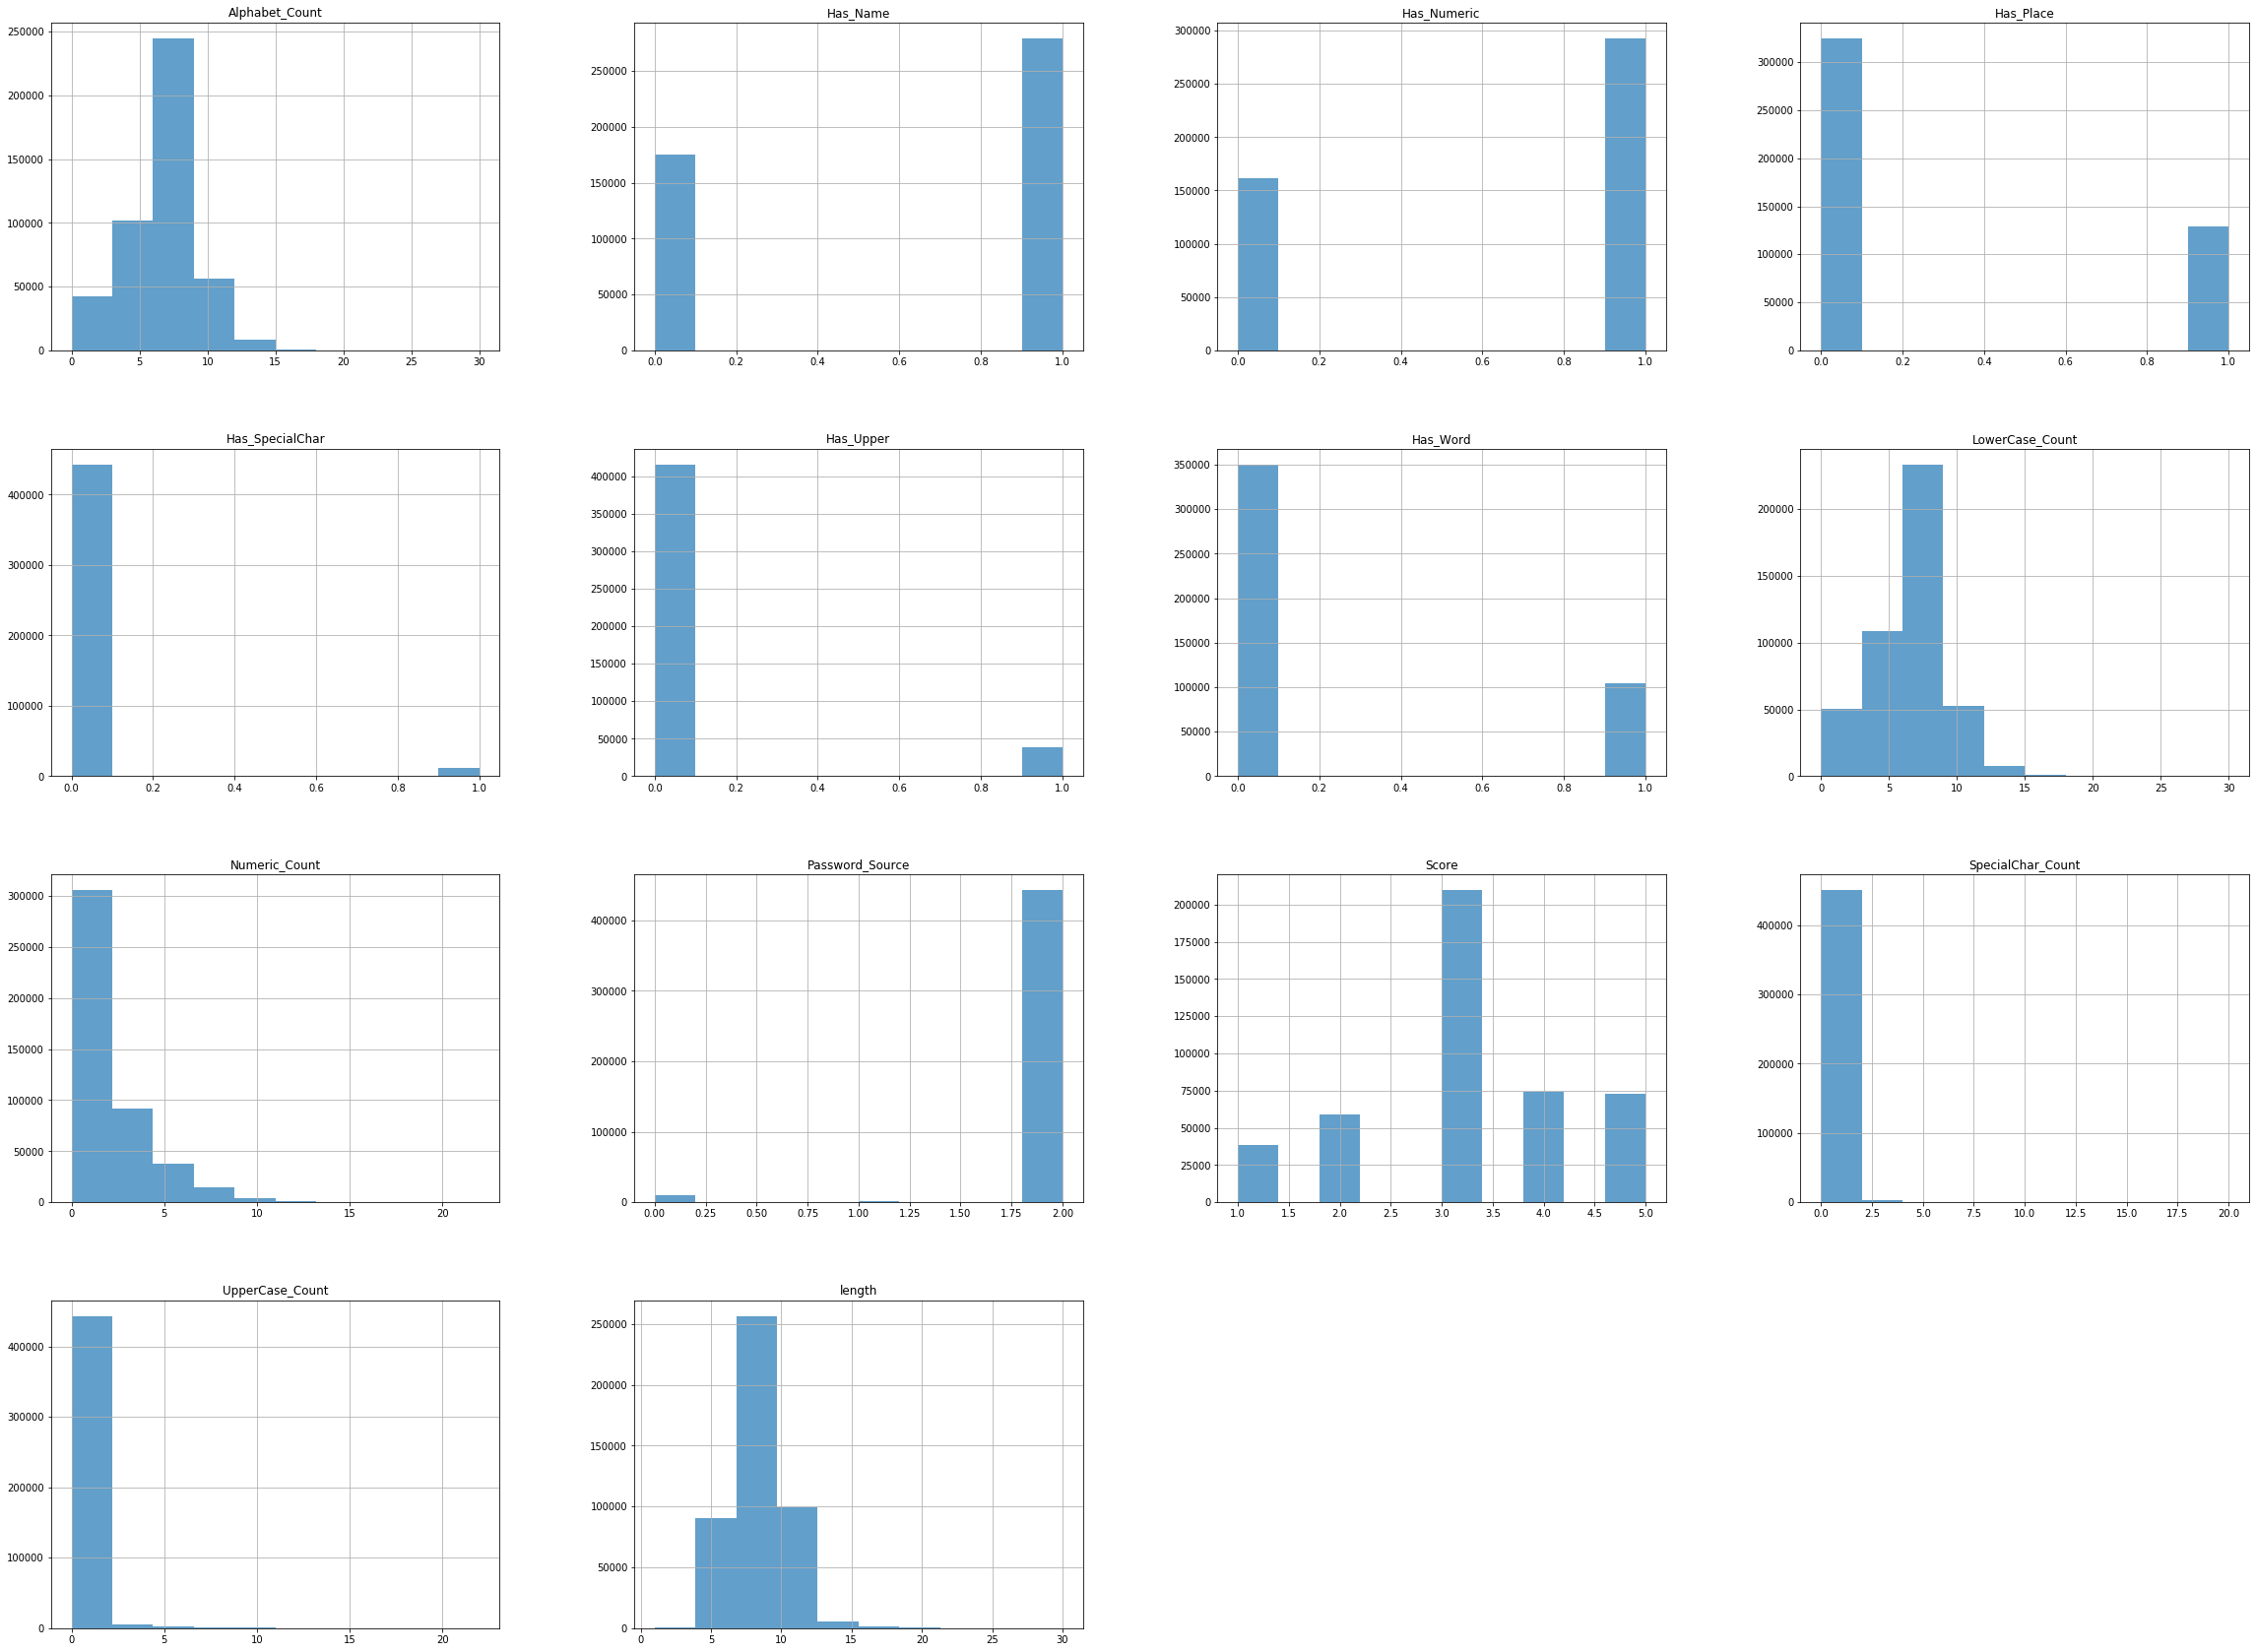

In [7]:
df_full.hist(figsize=(40,30), alpha=0.7);

In [8]:
df_full = df_full.drop(['Has_Numeric','Has_Word','Has_Name','Has_Place'], axis=1)

#### Lets set our target and feature data

In [9]:
#Dependent variable / target --> Score
#Features / Predictors --> all other

target = df_full.Score
features = df_full.drop(['Passwords','Score','Password_Strength'], axis = 1)

#### Now lets visualize the correlation of the features to see if there are any additional features that can be eliminated.

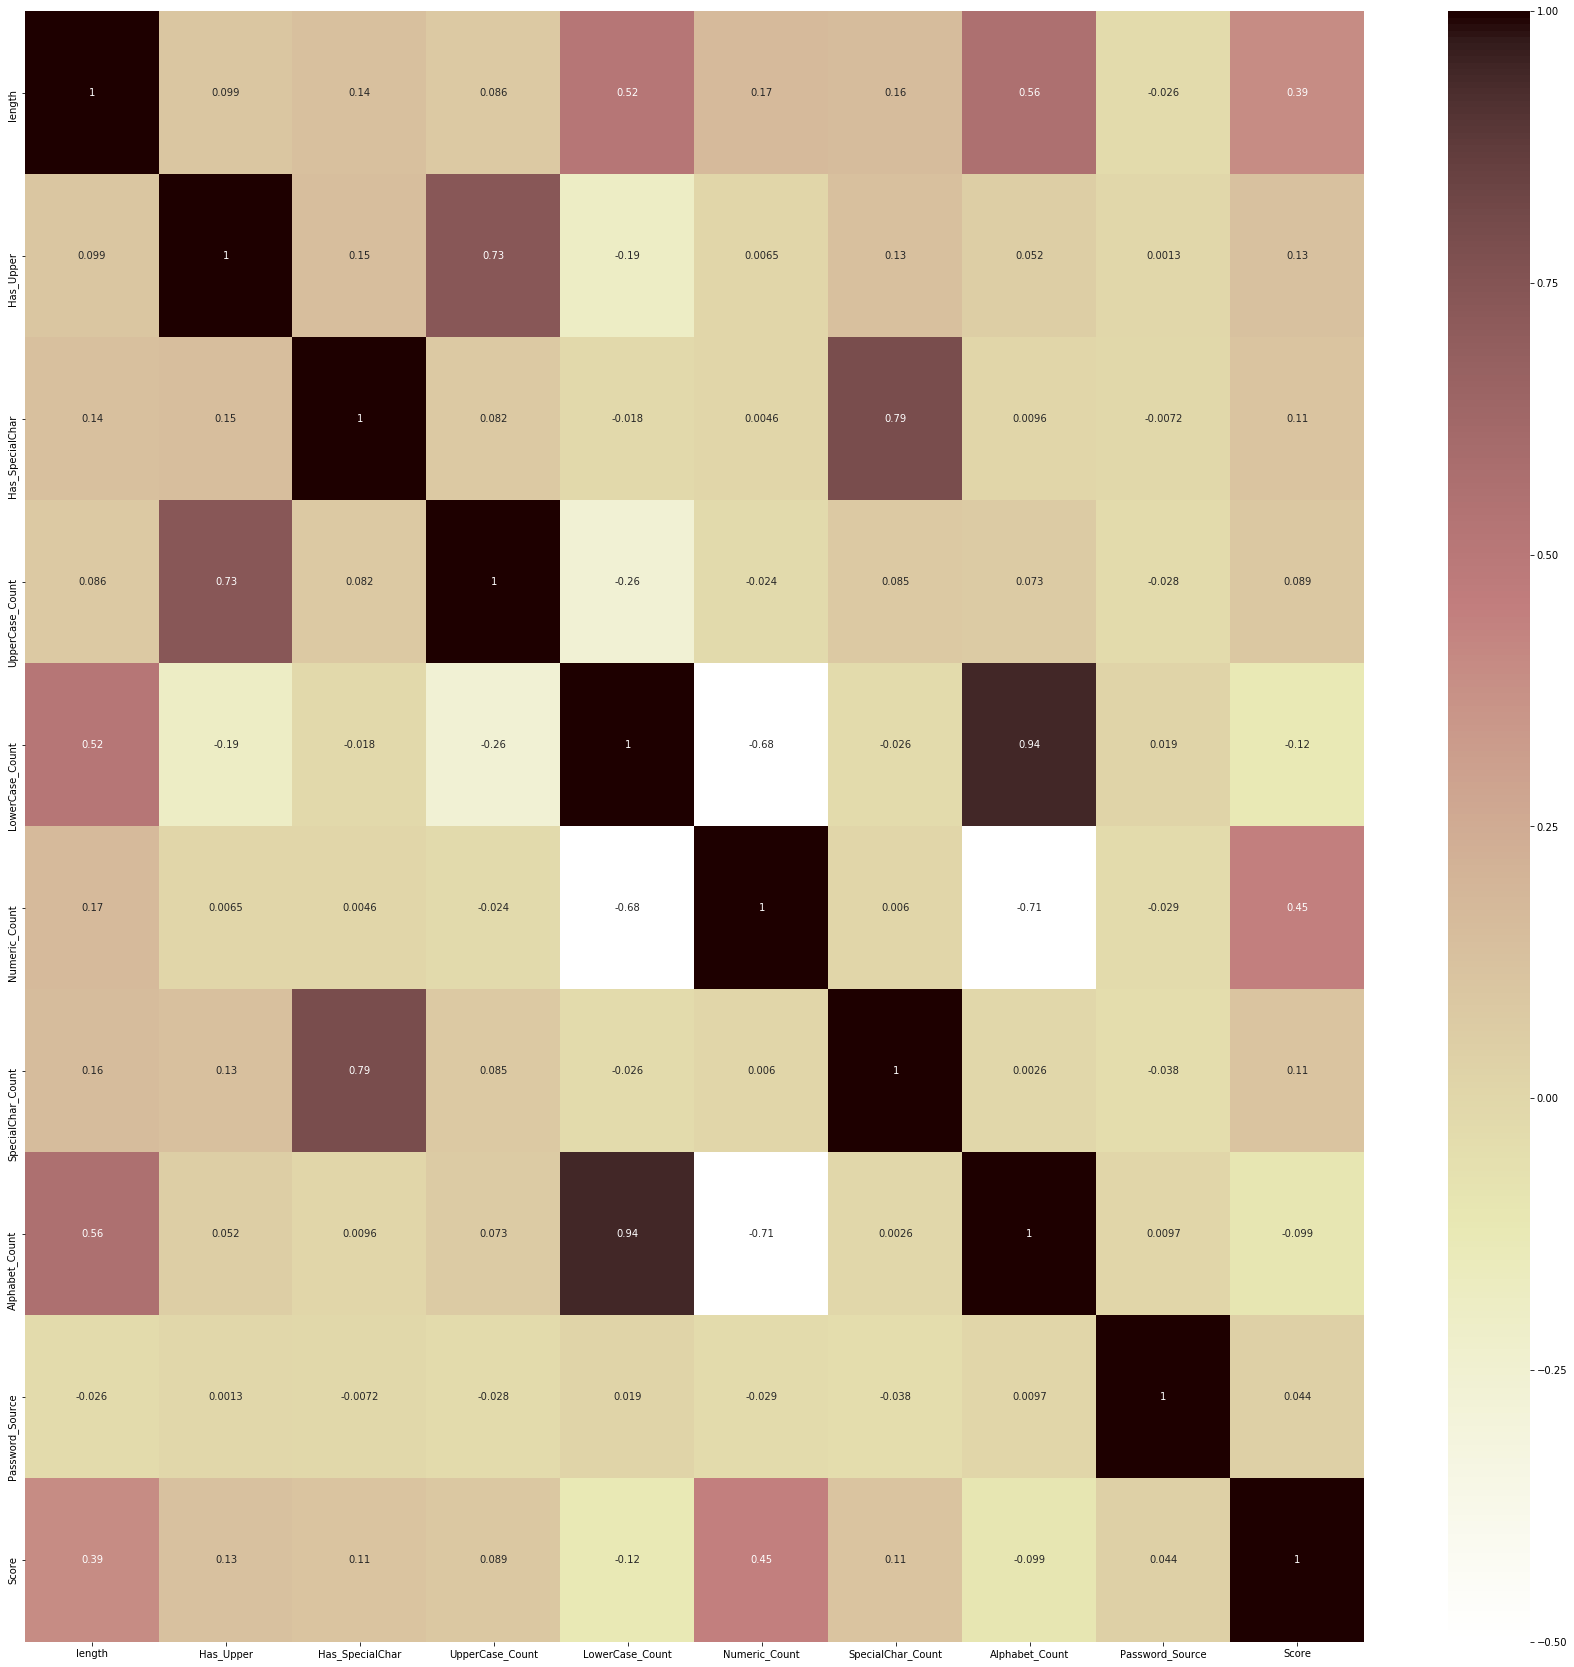

In [10]:
correlation = df_full.corr()
plt.figure(figsize=(30,30))
heatmap = sns.heatmap(correlation, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')

#### Next, we compare the correlation between features and remove one of two features that have a correlation higher than 0.9

In [11]:
columns = np.full((correlation.shape[0],), True, dtype=bool)
x = []
for i in range(correlation.shape[0]):
    for j in range(i+1, correlation.shape[0]):
        if correlation.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                x.append(j)
                

var =  df_full.columns[x[0]+1]
features = features.drop([var], axis = 1)
features.head()

,length,Has_Upper,Has_SpecialChar,UpperCase_Count,LowerCase_Count,Numeric_Count,SpecialChar_Count,Password_Source
0,10,0,1,0,6,1,3,2
1,4,0,0,0,4,0,0,2
2,7,0,0,0,7,0,0,2
3,6,0,0,0,6,0,0,2
4,6,0,0,0,2,4,0,2


we dropped 'alphabet count' as it is highly correlated with 'lower case count'

# Modeling
## Muliple Linear Regression

### Univariate Selection

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

Below I used chi-squared (chi²) statistical test for non-negative features to select best features.

In [12]:
X = features  #independent columns
y = target    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print all features

               Specs          Score
5      Numeric_Count  282855.588945
4    LowerCase_Count   69874.966221
0             length   45036.523454
3    UpperCase_Count   17758.412276
6  SpecialChar_Count   12911.011755
1          Has_Upper    7966.805864
2    Has_SpecialChar    6081.040274
7    Password_Source      61.002386


In [13]:
#Eliminate  Has_Upper, Has_SpecialChar and Password_Source
features_lin = features.drop(['Has_Upper', 'Has_SpecialChar', 'Password_Source'], axis=1)

In [14]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
f_scale = ss.fit_transform(features_lin)

In [15]:
#Modeling
#X_train, X_test, y_train, y_test = train_test_split (f_scale, target, random_state=0)
X_train, X_test, y_train, y_test = train_test_split (features, target, test_size=0.2, random_state=0)

                    Coefficient
length             4.899804e+10
Has_Upper          3.444636e-01
Has_SpecialChar    2.930196e-01
UpperCase_Count   -4.899804e+10
LowerCase_Count   -4.899804e+10
Numeric_Count     -4.899804e+10
SpecialChar_Count -4.899804e+10
Password_Source    2.379736e-01


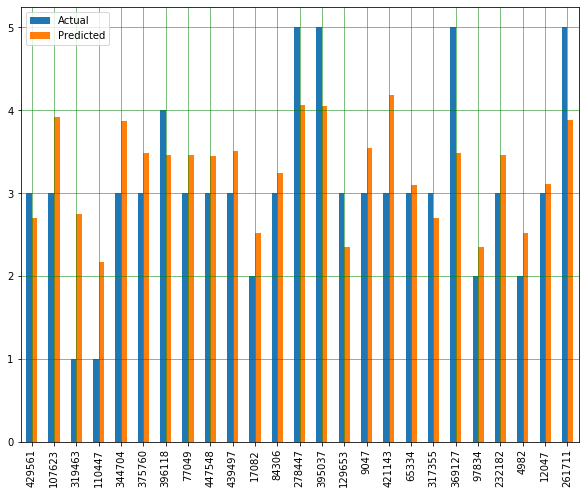

In [16]:
#https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df)
y_pred = regressor.predict(X_test)
df23 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df123 = df23.head(25)
df123.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [17]:
model = LinearRegression()
lin = model.fit(X_train, y_train)
y_predict = model.predict(X_test)

y_predict = y_pred.astype(int)

y_predict = np.array([x for x in y_predict if x <= 5])
x1 = y_test.shape[0] - y_predict.shape[0]

while(x1>0):
    y_predict = np.append(y_predict, 5)
    x1=x1-1

In [18]:
cnf_matrix_lin = confusion_matrix(y_test, y_predict)

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[   57  3156  3578   760    88]
 [   86  4857  5517  1122   108]
 [  242 17389 19887  4131   437]
 [  102  6108  7066  1454   167]
 [   82  6030  6932  1406   135]]


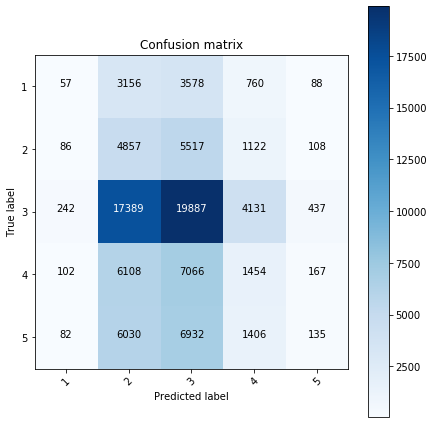

In [20]:
plot_confusion_matrix(cnf_matrix_lin, classes=[1,2,3,4,5])

In [21]:
Y_pred = model.predict(X_train)
error = (Y_pred - y_train)**2
msetrain = round(np.mean(error),3)
print('LinearRegression -- Mean square error on train set: ', msetrain)

Y_pred_t = model.predict(X_test)
error_t = (Y_pred_t - y_test)**2
msetest = round(np.mean(error_t),3)
print('LinearRegression -- Mean square error on test set: ', msetest)

LinearRegression -- Mean square error on train set:  0.843
LinearRegression -- Mean square error on test set:  0.841


In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(363585, 8)
(90897, 8)
(363585,)
(90897,)


## Logistic Regression

### Recursive Feature Elimination

In [23]:
# Recursive Feature Elimination
# Feature Extraction with RFE

# Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.

# It uses the model accuracy to identify which attributes contribute the most to predicting the target attribute.

# length, specialchar_Count and Numeric_count has more contribution towards the target attr 

X = features
Y = target
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [ True False False False False  True  True False]
Feature Ranking: [1 6 2 4 3 1 1 5]


In [24]:
features_log = features.drop(['Has_Upper','Numeric_Count','SpecialChar_Count'], axis = 1)

### Logistic Regression

In [25]:
ss=StandardScaler()
f_scale = ss.fit_transform(features_log)

In [26]:
# Modeling
X_train, X_test, y_train, y_test = train_test_split (f_scale,target, random_state=0)

In [27]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_predict)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(340861, 5)
(113621, 5)
(340861,)
(113621,)


Confusion matrix, without normalization
[[ 7010     8  2541     0     0]
 [ 3857   151 10172   379    31]
 [ 2035   146 47126  1726  1515]
 [    0   110 17588   698   287]
 [    0     0 16777    81  1383]]


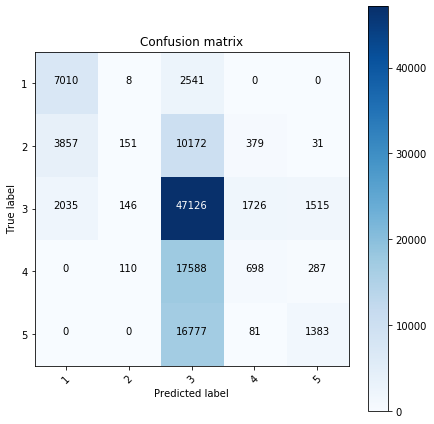

In [29]:
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5]) #25%

In [30]:
Logregpredtrain = model.predict(X_train)
# Calculate the Square errors
Logregerrortrain = (Logregpredtrain - y_train)**2
LogregMSEtrain =  round(np.mean(Logregerrortrain),3)
print('Mean Square Error Train:', LogregMSEtrain)

Logregpredtest = model.predict(X_test)
Logregerrortest = (Logregpredtest - y_test)**2
LogregMSEtest = round(np.mean(Logregerrortest),3)
print('Mean Square Error Test:', LogregMSEtest)

Mean Square Error Train: 1.129
Mean Square Error Test: 1.123


(340861, 5)
(113621, 5)
(340861, 5)
(113621, 5)


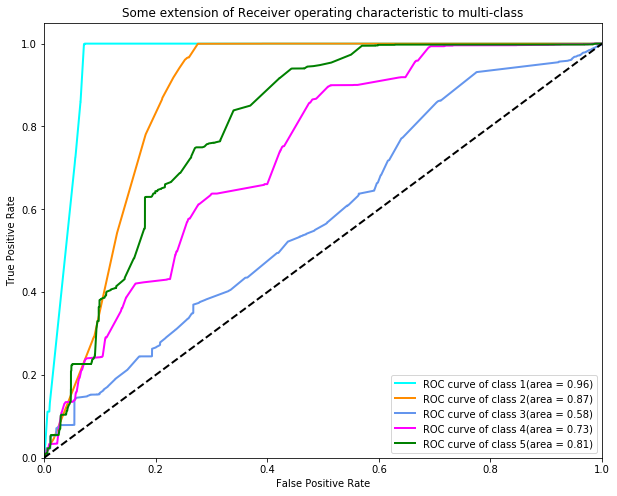

In [31]:
target_bin = label_binarize(target, classes=[1,2,3,4,5])
n_classes = 5
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split (features_log,target_bin, random_state=0)
print(X_train_bin.shape)
print(X_test_bin.shape)
print(y_train_bin.shape)
print(y_test_bin.shape)

model_bin = OneVsRestClassifier(LogisticRegression(random_state=0))

# model = LogisticRegression(random_state=0, multi_class='ovr')
y_score_bin = model_bin.fit(X_train_bin, y_train_bin).decision_function(X_test_bin)

y_predict_bin = model.predict(X_test_bin)

# First aggregate all false positive rates


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw =2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure(figsize=(10, 8))


colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'magenta', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class ' + str(i+1) +  '(area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Random Forest Model

### Feature Importance

You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.


In [32]:
X = features 
y = target

[0.29110959 0.01472041 0.0071518  0.01739839 0.35086454 0.30742489
 0.0072743  0.00405608]


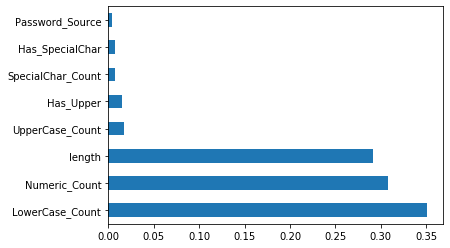

In [33]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()

In [34]:
features_reg= features.drop(['Password_Source','Has_SpecialChar','SpecialChar_Count'], axis = 1)

In [35]:
# StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance.
ss=StandardScaler()
f_scale = ss.fit_transform(features_reg)

Confusion matrix, without normalization
[[ 9543  4342  2537     0     0]
 [    0  3781  3750   378     0]
 [   16  6426 40999 10990  7972]
 [    0    41  3255  5927   568]
 [    0     0  2007  1388  9701]]


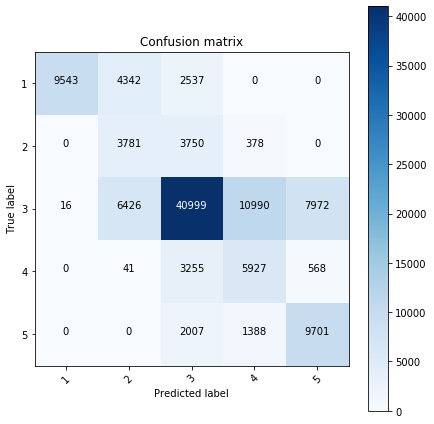

In [36]:
X_train, X_test, y_train, y_test = train_test_split(f_scale,target, random_state=0)
#Initial Model
ranfor = RandomForestClassifier()

y_score = ranfor.fit(X_train, y_train)
pred = ranfor.predict(X_test)
y_hat_test = ranfor.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5])

### Mean Square Error

In [37]:
# Print Random Forest Regression Mean Square Error for Team 1

rfPredictTrain = ranfor.predict(X_train)
# Calculate the Square errors
rfErrorTrain = (rfPredictTrain - y_train)**2
rfTrainMSE =  round(np.mean(rfErrorTrain),3)
print('Mean Square Error Train:', rfTrainMSE)



rfPredictTest = ranfor.predict(X_test)
rfErrorTest = (rfPredictTest - y_test)**2
rfTestMSE = round(np.mean(rfErrorTest),3)
print('Mean Square Error Test:', rfTestMSE)

Mean Square Error Train: 0.724
Mean Square Error Test: 0.726


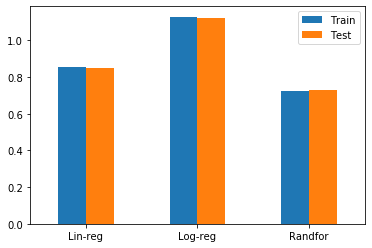

In [38]:
Train = [0.854, 1.129, 0.724]
Test = [0.852, 1.123, 0.727]
index = ['Lin-reg','Log-reg','Randfor']
df = pd.DataFrame({'Train': Train, 'Test': Test}, index=index)
ax = df.plot.bar(rot=0)